In [1]:
import os
import h5py
import numpy as np 

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
dir_cmx = '/Users/ChangHoon/data/feasiBGS/cmx/'

Read sky fibers and observing conditions 

In [4]:
fsky = h5py.File(os.path.join(dir_cmx, 'sky_fibers.coadd_gfa.minisv2_sv0.hdf5'), 'r')
sky_data = {}
for k in fsky.keys():
    sky_data[k] = fsky[k][...]
sky_flux_b = sky_data['flux_b'] + sky_data['sky_b']
sky_flux_r = sky_data['flux_r'] + sky_data['sky_r']
sky_flux_z = sky_data['flux_z'] + sky_data['sky_z']

[]

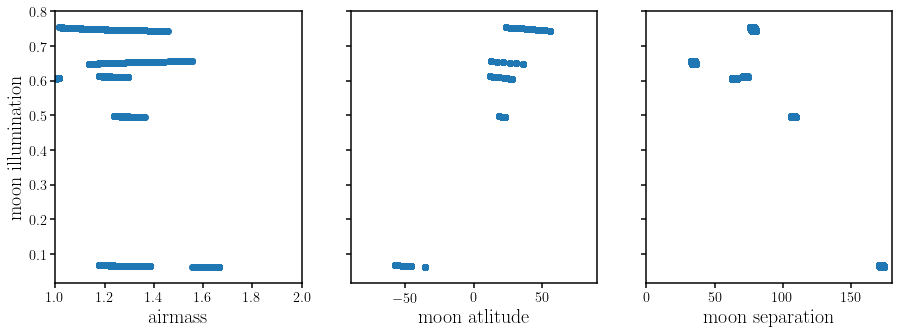

In [14]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(sky_data['airmass'], sky_data['moon_ill'])
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(sky_data['moon_alt'], sky_data['moon_ill'])
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(sky_data['moon_sep'], sky_data['moon_ill'])
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

No exposures during twilight

Text(0, 0.5, 'sun altitude')

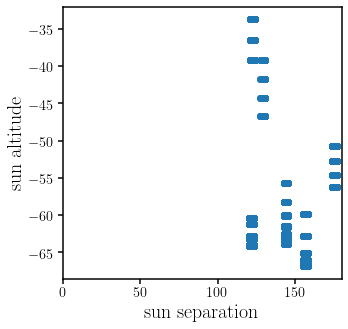

In [15]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.scatter(sky_data['sun_sep'], sky_data['sun_alt'])
sub.set_xlabel('sun separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_ylabel('sun altitude', fontsize=20)

In [52]:
from astropy import units as u
from feasibgs import skymodel as Sky

def sky_model_notwi(airmass, moonill, moonalt, moonsep):
    ''' calculate sky brightness using rescaled KS coefficients plus a twilight
    factor from Parker.

    :return specsim_wave, Isky:
     returns wavelength [Angstrom] and sky surface brightness [$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]
    '''
    specsim_sky = Sky._specsim_initialize('desi')
    specsim_wave = specsim_sky._wavelength # Ang
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg

    # updated KS coefficients
    specsim_sky.moon.KS_CR = 458173.535128
    specsim_sky.moon.KS_CM0 = 5.540103
    specsim_sky.moon.KS_CM1 = 178.141045

    I_ks_rescale = specsim_sky.surface_brightness
    Isky = I_ks_rescale.value * (1.46/2.)**2 * np.pi #1.46 arcsec is the fiber core diamaeter

    return specsim_wave.value, Isky

In [53]:
bright_exps = np.unique(sky_data['expid'][sky_data['moon_alt'] > 0])

/anaconda2/envs/bgs/lib/python3.7/site-packages/speclite-0.8-py3.7.egg/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


Text(0.5, 1.0, 'airmass=1.19, moon ill=0.75, moon altitutde=43.5, moon separation=78.7, no twilight')

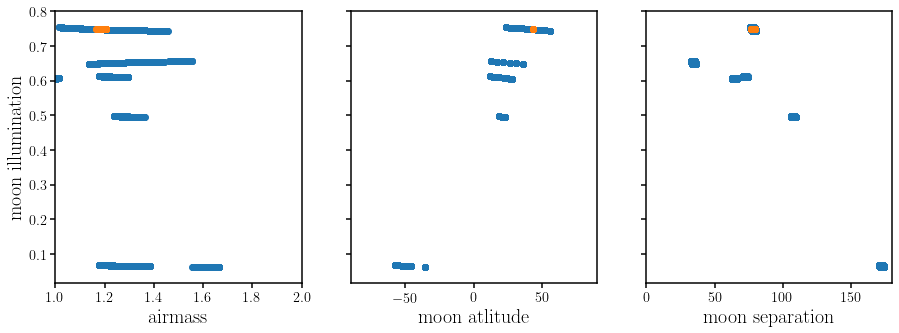

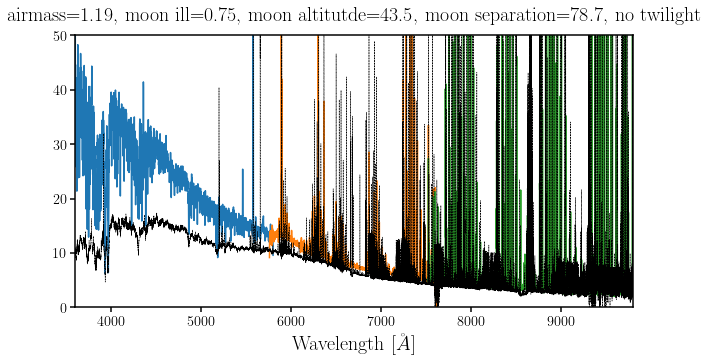

In [54]:
is_exp0 = (sky_data['expid'] == bright_exps[10])

fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(sky_data['airmass'], sky_data['moon_ill'])
sub.scatter(sky_data['airmass'][is_exp0], sky_data['moon_ill'][is_exp0])
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(sky_data['moon_alt'], sky_data['moon_ill'])
sub.scatter(sky_data['moon_alt'][is_exp0], sky_data['moon_ill'][is_exp0])
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(sky_data['moon_sep'], sky_data['moon_ill'])
sub.scatter(sky_data['moon_sep'][is_exp0], sky_data['moon_ill'][is_exp0])
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(sky_data['wave_b'], np.median(sky_data['sky_b'][is_exp0,:], axis=0), c='C0')
sub.plot(sky_data['wave_r'], np.median(sky_data['sky_r'][is_exp0,:], axis=0), c='C1')
sub.plot(sky_data['wave_z'], np.median(sky_data['sky_z'][is_exp0,:], axis=0), c='C2')
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=20)

_wave, _Isky = sky_model_notwi(np.median(sky_data['airmass'][is_exp0]), np.median(sky_data['moon_ill'][is_exp0]), 
               np.median(sky_data['moon_alt'][is_exp0]), np.median(sky_data['moon_sep'][is_exp0]))
sub.plot(_wave, _Isky, c='k', ls='--', lw=0.5)
sub.set_xlim(3600., 9800.)
sub.set_ylim(0., 50)
sub.set_title('airmass=%.2f, moon ill=%.2f, moon altitutde=%.1f, moon separation=%.1f, no twilight' % 
              (np.median(sky_data['airmass'][is_exp0]), np.median(sky_data['moon_ill'][is_exp0]), 
               np.median(sky_data['moon_alt'][is_exp0]), np.median(sky_data['moon_sep'][is_exp0])), 
              pad=15, fontsize=20) 

/anaconda2/envs/bgs/lib/python3.7/site-packages/speclite-0.8-py3.7.egg/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


Text(0.5, 1.0, 'airmass=1.30, moon ill=0.50, moon altitutde=20.5, moon separation=107.7, no twilight')

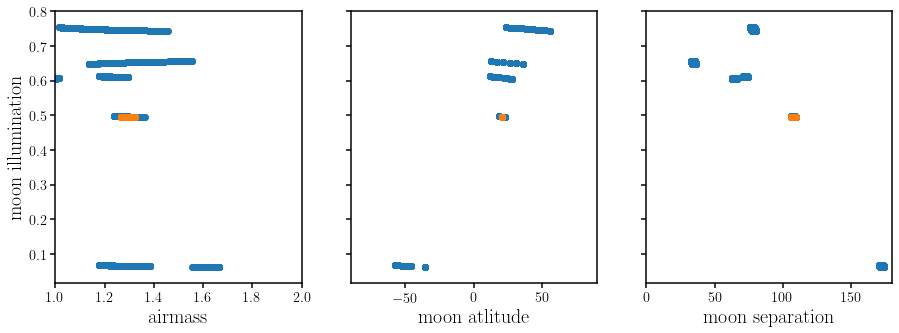

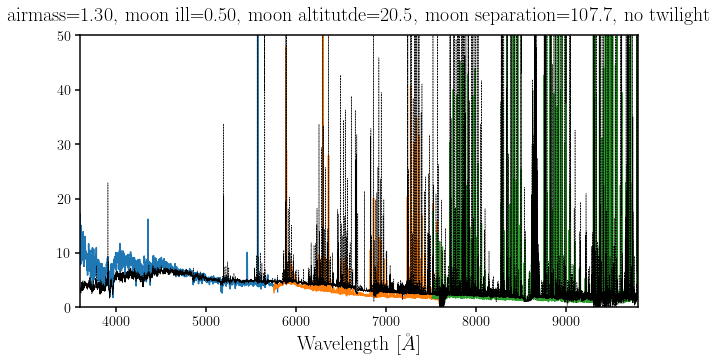

In [55]:
is_exp0 = (sky_data['expid'] == bright_exps[27])

fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(sky_data['airmass'], sky_data['moon_ill'])
sub.scatter(sky_data['airmass'][is_exp0], sky_data['moon_ill'][is_exp0])
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(sky_data['moon_alt'], sky_data['moon_ill'])
sub.scatter(sky_data['moon_alt'][is_exp0], sky_data['moon_ill'][is_exp0])
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(sky_data['moon_sep'], sky_data['moon_ill'])
sub.scatter(sky_data['moon_sep'][is_exp0], sky_data['moon_ill'][is_exp0])
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(sky_data['wave_b'], np.median(sky_data['sky_b'][is_exp0,:], axis=0), c='C0')
sub.plot(sky_data['wave_r'], np.median(sky_data['sky_r'][is_exp0,:], axis=0), c='C1')
sub.plot(sky_data['wave_z'], np.median(sky_data['sky_z'][is_exp0,:], axis=0), c='C2')
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=20)

_wave, _Isky = sky_model_notwi(np.median(sky_data['airmass'][is_exp0]), np.median(sky_data['moon_ill'][is_exp0]), 
               np.median(sky_data['moon_alt'][is_exp0]), np.median(sky_data['moon_sep'][is_exp0]))
sub.plot(_wave, _Isky, c='k', ls='--', lw=0.5)
sub.set_xlim(3600., 9800.)
sub.set_ylim(0., 50)
sub.set_title('airmass=%.2f, moon ill=%.2f, moon altitutde=%.1f, moon separation=%.1f, no twilight' % 
              (np.median(sky_data['airmass'][is_exp0]), np.median(sky_data['moon_ill'][is_exp0]), 
               np.median(sky_data['moon_alt'][is_exp0]), np.median(sky_data['moon_sep'][is_exp0])), 
              pad=15, fontsize=20) 

/anaconda2/envs/bgs/lib/python3.7/site-packages/speclite-0.8-py3.7.egg/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


Text(0.5, 1.0, 'airmass=1.05, moon ill=0.75, moon altitutde=29.3, moon separation=78.1, no twilight')

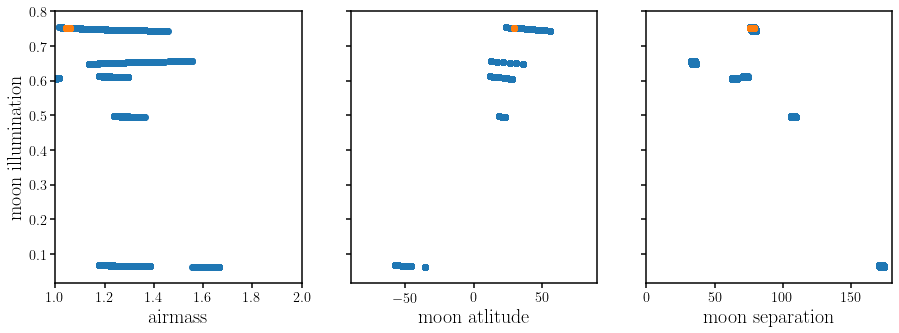

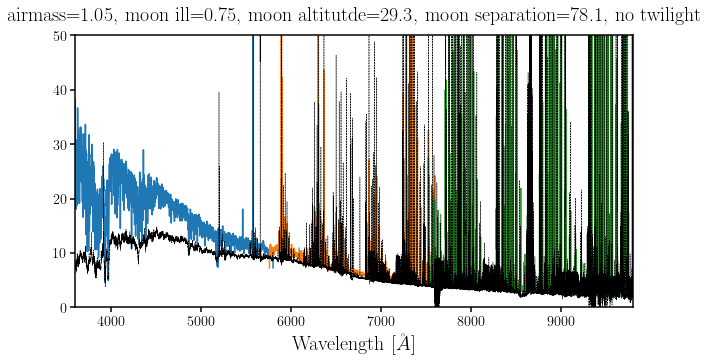

In [56]:
is_exp0 = (sky_data['expid'] == bright_exps[15])

fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(sky_data['airmass'], sky_data['moon_ill'])
sub.scatter(sky_data['airmass'][is_exp0], sky_data['moon_ill'][is_exp0])
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(sky_data['moon_alt'], sky_data['moon_ill'])
sub.scatter(sky_data['moon_alt'][is_exp0], sky_data['moon_ill'][is_exp0])
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(sky_data['moon_sep'], sky_data['moon_ill'])
sub.scatter(sky_data['moon_sep'][is_exp0], sky_data['moon_ill'][is_exp0])
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(sky_data['wave_b'], np.median(sky_data['sky_b'][is_exp0,:], axis=0), c='C0')
sub.plot(sky_data['wave_r'], np.median(sky_data['sky_r'][is_exp0,:], axis=0), c='C1')
sub.plot(sky_data['wave_z'], np.median(sky_data['sky_z'][is_exp0,:], axis=0), c='C2')
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=20)

_wave, _Isky = sky_model_notwi(np.median(sky_data['airmass'][is_exp0]), np.median(sky_data['moon_ill'][is_exp0]), 
               np.median(sky_data['moon_alt'][is_exp0]), np.median(sky_data['moon_sep'][is_exp0]))
sub.plot(_wave, _Isky, c='k', ls='--', lw=0.5)
sub.set_xlim(3600., 9800.)
sub.set_ylim(0., 50)
sub.set_title('airmass=%.2f, moon ill=%.2f, moon altitutde=%.1f, moon separation=%.1f, no twilight' % 
              (np.median(sky_data['airmass'][is_exp0]), np.median(sky_data['moon_ill'][is_exp0]), 
               np.median(sky_data['moon_alt'][is_exp0]), np.median(sky_data['moon_sep'][is_exp0])), 
              pad=15, fontsize=20) 